Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

%matplotlib inline

# Stochastic gradient Langevin dynamics, and uncertainty quantification

In this first part of the coursework you'll do two things:

* Implement stochastic gradient Langevin dynamics for sampling from a Bayesian neural network
* Break down the variance to estimate epistemic and aleatoric uncertainty

We're going to run this on the following toy 2D dataset, consisting of **two moons**, each a different class.

(-2.0, 2.0)

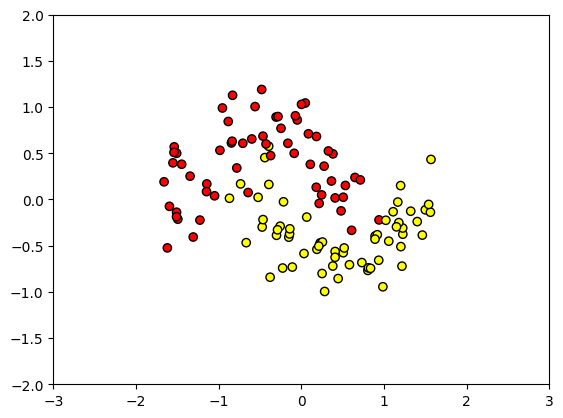

In [2]:
dataset, validation_set = torch.load("two_moons.pt")
X_train, y_train = dataset.tensors
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.xlim(-3,3)
plt.ylim(-2,2)

## We'll use the following simple feedforward network.

In [3]:
class TwoMoonsNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 100),
                        nn.ReLU(), 
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
        
    def forward(self, x):
        h = self.net(x)
        return torch.sigmoid(h).squeeze(1)
    
network = TwoMoonsNetwork()

# TASK 1 (5 points): Define the likelihood and the prior

Let $x_i \in \mathbb{R}^2$ denote an input, $y_i \in \{ 0, 1\}$ a target, and $\theta$ the network parameters.

Let $\hat y_i = f_\theta(x_i)$ denote the output of the network $f_\theta$.

You need to define:

* `log_likelihood`, evaluating a Bernoulli distribution $$\log p(y|x, \theta) = \log \mathrm{Bernoulli}(y | f_\theta(x));$$
* `log_prior`, evaluating a standard normal distribution $$\log p(\theta) = \log \mathcal{N}(\theta | 0, I).$$

Both of these functions should return a numeric scalar value.

For the prior, you will need to somehow access the parameters of the network! There are several ways of doing this. I suggest looking at the pytorch documentation for either

* iterating through `network.parameters()`, or
* using helper functions such as `nn.utils.parameters_to_vector`



In [4]:
def log_likelihood(network, X, y):
    """
    This function computes the log probability `log p(y | x, theta)`
    for a batch of inputs X.
    
    INPUT:
    network : instance of classifier network, extends `nn.Module`
    X       : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y       : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    
    OUTPUT:
    lp      : log probability value of log p(y | x, theta); scalar
    
    """
    
    batch, inputs = X.shape
    
    y_hat = network(X)
    
    log_like = dist.Bernoulli(y_hat).log_prob(y).sum(0)
    
    return log_like


In [5]:
# grading


In [6]:
def log_prior(network):

    log_prior_theta = 0.0
    
    for a in network.parameters() :
        flat = a.flatten()
        log_prior_theta += dist.Normal(torch.zeros(flat.shape), torch.ones(flat.shape)).log_prob(flat).sum(0)
    
    return log_prior_theta

In [7]:
# grading


In [8]:
# grading


# TASK 2 (3 points): Minibatching

Minibatching is "trickier" when we have a prior on the network parameters.

The function `log_joint_minibatch` should return a mini-batch estimate of the log joint of the full data, i.e. returning an estimator of $$\log p(\theta) + \sum_{i=1}^N \log p(y_i | x_i, \theta)$$ but which is evaluated on only the specified subset of the $N$ data points.

In [9]:
def log_joint_minibatch(network, X_batch, y_batch, N_training):
    """ Return a minibatch estimate of the full log joint probability 
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set

    OUTPUT:
    lp : return an estimate of log p(y, theta | X), as computed on the batch; scalar.

    """
    logprior = log_prior(network)
    
    loglike = (N_training / len(y_batch)) * log_likelihood(network, X_batch, y_batch)
    
    return logprior + loglike
    
    

In [10]:
# grading


In [11]:
# grading


## Self-diagnostic

This is a small-enough dataset that we can compute the log joint probability on the whole dataset:

In [12]:
with torch.no_grad():
    full_data_lp = log_prior(network) + log_likelihood(network, X_train, y_train)
print("Full data log probability: %0.4f" % full_data_lp.item())

Full data log probability: -1322.8730


### In the next cell, we call `log_joint_minibatch`.

If all the code is working correctly, the minibatch estimates should be roughly normally-distributed around the true value!

Changing the batch size should not change the mean of this distribution. Try running the cell below several times.

If the histogram is far away from the true value (the black vertical dashed line), then you probably have a bug.

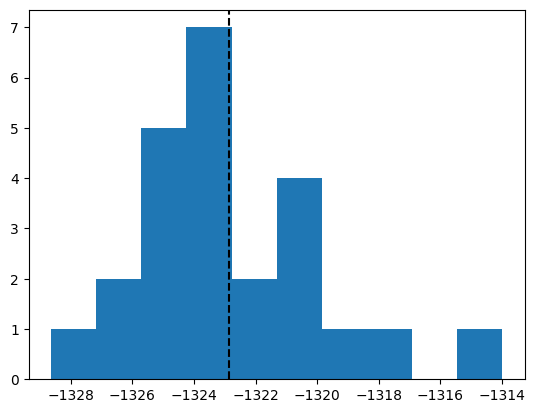

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)

with torch.no_grad():
    batch_lp_est = [log_joint_minibatch(network, X, y, len(dataset)).item() for X, y in dataloader]
plt.hist(batch_lp_est, bins=10);
yl = plt.ylim()
plt.plot(full_data_lp.item()*np.ones(2), [0, plt.ylim()[1]], 'k--')
plt.ylim(yl);
# torch.stack(batch_lp_est).sum()

## Train the model (MAP estimation)

Run the following cell to train your model, to find a MAP estimate.

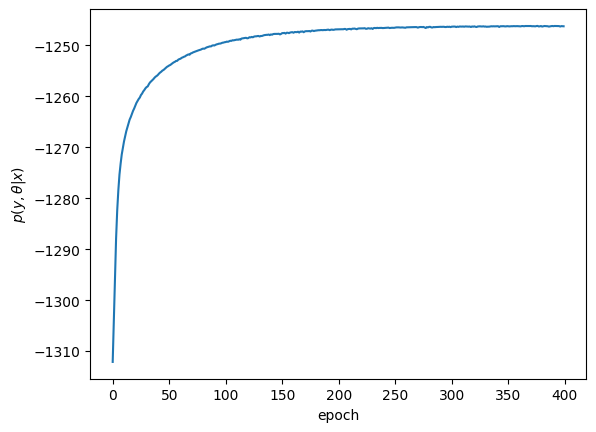

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)
opt = torch.optim.Adam(network.parameters())

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader:
        opt.zero_grad()
        loss = -log_joint_minibatch(network, X, y, len(dataset))
        loss.backward()
        opt.step()
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item())
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

## Confidence plot

To visualize the result, we'll look at a *confidence plot*.

The *confidence* is the probability assigned to whichever class is predicted.

If the most likely class is "yellow", then it shows $p(y = \text{yellow})$. If the most likely class is red, it shows $p(y = \text{red})$.



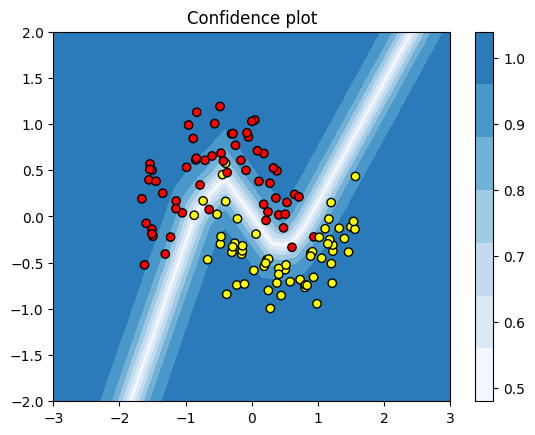

In [15]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    py = network(torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T))
    conf = torch.where(py > 0.5, py, 1-py) ## THIS LINE COMPUTES THE CONFIDENCE
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");

# Calibration and reliability diagrams

I've implemented a reliability diagram plot and expected calibration error computation here.

Could be interesting to see how the number of bins affects the result…!

In [16]:
def reliability_diagram(y, y_hat, N_bins=10):
    """
    Plot a reliability diagram
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    freq = [y[which_bin==k].mean().item() for k in range(N_bins)]
    conf = [y_hat[which_bin==k].mean().item() for k in range(N_bins)]
    plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);
    plt.plot(conf, freq, 'o-', color='k')
    plt.plot([0, 1], [0, 1], '--', color='#333');

def expected_calibration_error(y, y_hat, N_bins=10):
    """
    Compute the expected calibration error
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    counts = []
    acc = []
    conf = []
    for k in range(N_bins):
        count = len(y[which_bin==k])
        if count > 0:
            acc.append(y[which_bin==k].mean().item())
            conf.append(y_hat[which_bin==k].mean().item())
        else:
            acc.append(0.0)
            conf.append(0.0)
        counts.append(count)
    return ((np.abs(np.array(acc) - np.array(conf))*np.array(counts))/len(y)).sum()

ECE = 0.0515


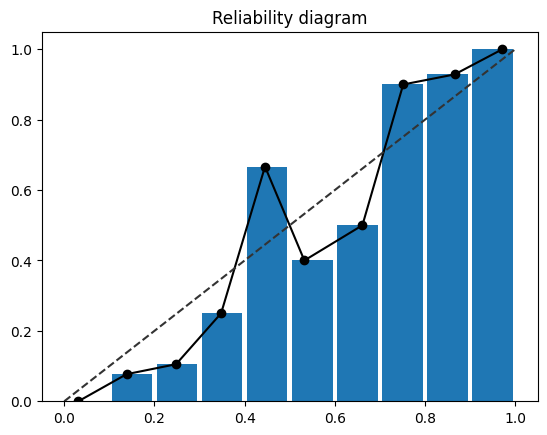

In [17]:
with torch.no_grad():
    y_hat = network(validation_set.tensors[0])

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))
plt.title("Reliability diagram");

# TASK 3 (6 points): stochastic gradient Langevin dynamics (SGLD)

In this task you can get

* 3 points for implementing the SGLD MCMC update
* 3 points for implementing Monte Carlo prediction

The `SGLD_step` function below should take a current set of network parameters $\theta$, and update them as

$$\theta' = \theta + \frac{\epsilon^2}{2} \nabla_\theta \log p(\theta, y | X) + \epsilon z$$

where $\epsilon$ is a learning rate, $X, y$ are a current mini-batch, and $z \sim \mathcal{N}(0, I)$ and has the same dimensionality as $\theta$.

For more details see the week 7 lecture slides!

Note that you will actually have to **do the update**. The following function does not return anything! Instead, it updates the parameters of the network, similar to how a `torch.optim` optimizer updates the parameters.

In [18]:
def SGLD_step(network, X, y, N_training, epsilon):
    """
    Run one step of SGLD given a mini-batch, and update the parameters of the network.
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set
    epsilon    : step size / learning rate parameters (scalar)
    """
    
    # theta' = theta + (ep^2 / 2) * g_hat + ep*momentum
            # g_hat = grad(log_joint)
    
    opt = torch.optim.SGD(network.parameters(), lr = 1.0)
    opt.zero_grad()
    logjoint = log_joint_minibatch(network, X, y, N_training)
    logjoint.backward()
    
    for theta in network.parameters() :
        g_hat = theta.grad
        flat = theta.flatten()
        momentum = dist.Normal(torch.zeros(flat.shape), torch.ones(flat.shape)).sample()
        theta_update = flat + ((epsilon**2/2) * (g_hat.flatten())) + (epsilon * momentum)
        theta.data = theta_update.reshape(theta.shape)

            
# WAY 3 - LAST MINUTE ERROR HOLDING UP THIS ONE :(
    
#     for theta in network.parameters() :
        
#         gradient = theta.grad
        
#         momentum = dist.Normal(torch.zeros(theta.shape), torch.ones(theta.shape)).sample()
        
#         dim = len(theta.shape)
#         if dim == 2 :
#             h, w = theta.shape
#             area = h * w
#             update = torch.zeros(theta.shape)
#             update[:,0] = theta[:,0] + ((epsilon**2/2) * (gradient[:,0])) + (epsilon * momentum[0])
#             update[0,:] = theta[0,:] + ((epsilon**2/2) * (gradient[:,0])) + (epsilon * momentum[1])
#             update.reshape(theta.shape)
#         else : 
#             h = theta.shape
#             update = torch.zeros(theta.shape)
#             update = theta + ((epsilon**2/2) * (gradient)) + (epsilon * momentum)
#             update.reshape(theta.shape)
        
#         theta.data = update.reshape(theta.shape)

In [19]:
# grading


In [20]:
# grading


### Cyclic learning rate 

We're going to use a cyclic learning rate schedule for $\epsilon$, like discussed in the lectures. That function is pre-written, below.

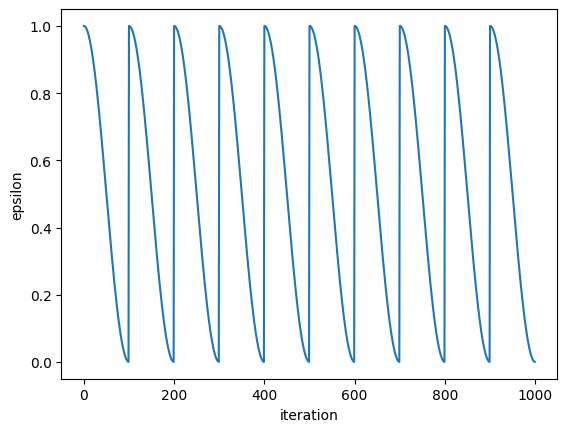

In [21]:
def learning_rate_schedule(N_steps, N_samples, epsilon):
    """
    Pre-compute a learning-rate schedule for SGLD.
    
    INPUT:
    N_steps   : number of SGD updates between each "reset"
    N_samples : number of times we reach the lowest target learning rate
    epsilon   : base learning rate
    
    OUTPUT:
    epsilon_t : vector of length N_steps*N_samples, containing epsilon_t at each iteration t
    """
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)

plt.plot(learning_rate_schedule(N_steps=100, N_samples=10, epsilon=0.5));
plt.xlabel("iteration");
plt.ylabel("epsilon");

### Running the sampler
The following function is also given: it will actually run the SGLD sampler, by calling your `SGLD_step` function above.

In [22]:
def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.02):
    """
    Draw samples using SGLD, following a prescribed learning rate schedule
    
    OUTPUT:
    samples : torch.FloatTensor, shape = (N_samples, "# of parameters in network")
    """
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)


In [23]:
samples = draw_sgld_samples(network, N_samples=50, N_steps_per_sample=200)
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([50, 1321])


## Making predictions

After running the sampler, you now have a `torch.FloatTensor` which contains many different sampled versions of the network parameters $s = 1,\dots,S$.

To make predictions on an input batch $X$, you will somehow need to "load" in the stored parameters, and run the forward pass using different $\theta^{(s)}$.

In [24]:
def predict_from_samples(X, network, samples):
    """
    
    INPUT:
    X       : batch of input points at which to make predictions; shape = (batch_size, 2)
    network : instance of classifier network, extends `nn.Module`
    samples : torch.FloatTensor containing samples of theta; shape = (num_samples, "# of parameters in network")
    
    OUTPUT:
    y_hat_samples : torch.FloatTensor containing samples of y_hat; shape = (num_samples, batch_size)
    """
    
    batch_size, inputs = X.shape
    
    num_samples, num_params = samples.shape
    
    y_hat = torch.zeros([num_samples, batch_size])
    
    for i in range(num_samples) :
        theta_samples = samples[i,:]
        for theta in network.parameters() :
            remove = theta.numel()
            theta_sample = theta_samples[:remove]
            theta.data = theta_sample.reshape(theta.shape)
            theta_samples = theta_samples[remove:]
        y_hat[i,:] = network(X)
    return y_hat
    

In [25]:
# The following should be true if your code is working!
assert predict_from_samples(X_train, network, samples).shape == (samples.shape[0], X_train.shape[0])

In [26]:
# grading


In [27]:
# grading


## Confidence plot and reliability diagrams for the Bayesian classifier

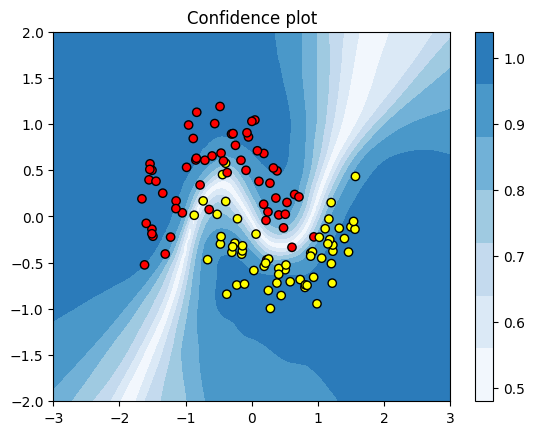

In [28]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    XXYY = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    out = predict_from_samples(XXYY, network, samples)
    py = out.mean(0)
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.title("Confidence plot");

ECE = 0.0617


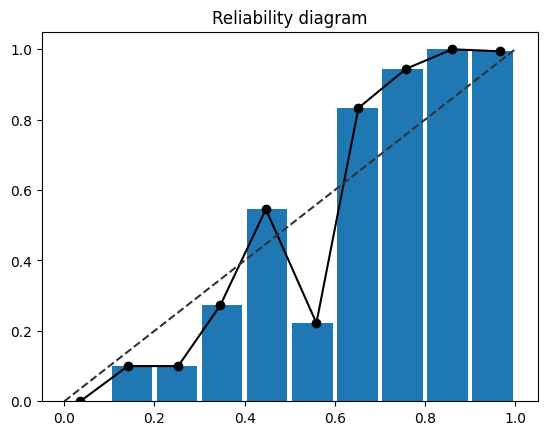

In [29]:
with torch.no_grad():
    y_hat = predict_from_samples(validation_set.tensors[0], network, samples).mean(0)

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))

plt.title("Reliability diagram");

## Uncertainty quantification

We can measure the uncertainty in our predictor by looking at the variance of the predictive distribution

$$p(y | \hat y).$$

Here, $\hat y$ is the posterior mean: the average $p(y = 1)$ estimated across all posterior samples.

The total predictive variance of $y$ is the variance of this distribution, i.e.

$$Var [ y | x ] = Var \left [ \int p(y | x, \theta)p(\theta | \mathcal{D}) d\theta \right]$$

One way to estimate epistemic and aleatoric uncertainty is to look at the variance of $\hat y$, i.e. the variance in $f_\theta(x)$ under the posterior over $\theta$. This corresponds to epistemic uncertainty. The difference between these two is then roughly the aleatoric uncertainty.

There are probably better ways to compute (and explain!) this, but hopefully the following plots look clear.

In [30]:
# Variance of predictive distribution over y
var_of_prediction = dist.Bernoulli(out.mean(0)).variance

# Epistemic uncertainty: Variance across values of y_hat
var_of_mean = out.var(0)



### Darker colors are more uncertain:

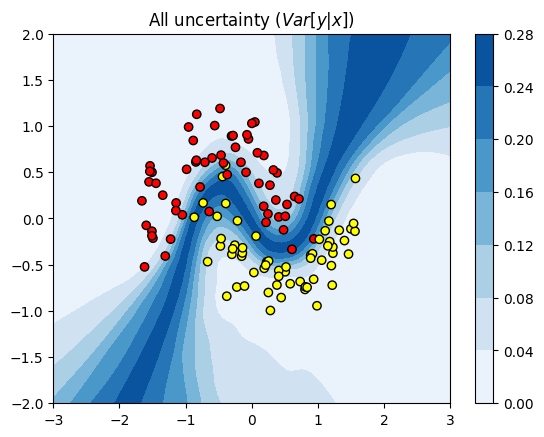

In [31]:
plt.title("All uncertainty ($Var[y | x]$)")
plt.contourf(XX, YY, var_of_prediction.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
# - torch.sigmoid(out).var(0).reshape(XX.shape))

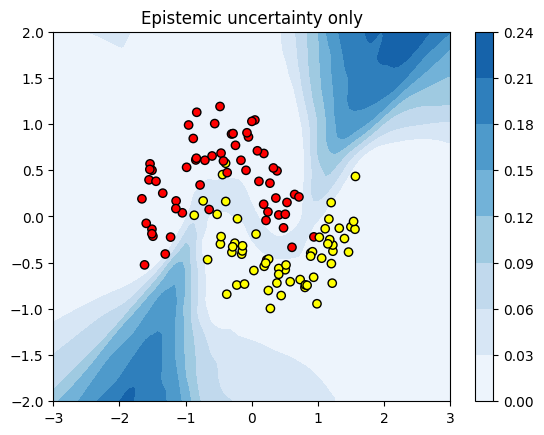

In [32]:
plt.title("Epistemic uncertainty only")
plt.contourf(XX, YY, var_of_mean.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.28)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

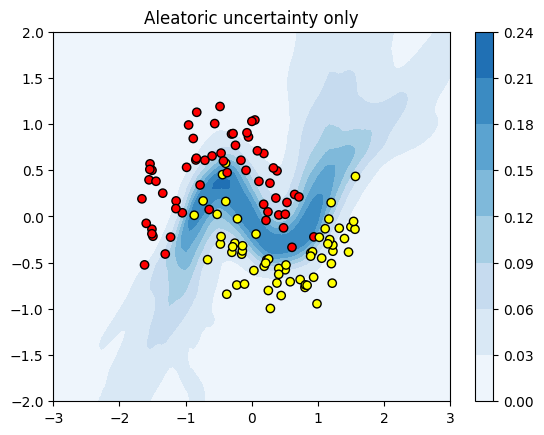

In [33]:
plt.title("Aleatoric uncertainty only")
plt.contourf(XX, YY, (var_of_prediction - var_of_mean).reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

# TASK 4 (up to 5 points, free response): Interpretation

Take a look at Figure 1 in the paper https://arxiv.org/pdf/2002.10118.pdf, "Being Bayesian, Even Just a Bit, Fixes Overconfidence in ReLU Networks", Kristiadi et al. 2020.

1. (4 points) Qualitatively, the uncertainty in figure 1 probably looks quite different from your plots in this notebook. Try to give two different reasons for why the results here might be different.
2. (1 point) What is going on with calibration / temperature scaling? Why doesn't the temperature scaling help in Figure 1 in the paper, and why doesn't the ECE improve in this case when we do sampling?

1. UNCERTAINTY FIGURE

The plots in this notebook look different because there are more components contributing to the approximation using this Stochastic Gradient Langevin Dynamics than the MAP, temperature scaling, and both last- and all-layer Gaussian approximations over Laplace approximated weights shown in Figure 1 in "Being Bayesian, Even Just a Bit, Fixes Overconfidence in ReLU Networks", Kristiadi et al. 2020. Reasons for why the results could differ include :

    (1) Laplace approximation typically uses sampling over the distribution but in our SGLD model we are sampling from a normal distribution. 

    (2) The incorporation the momentum and its input of Gaussian noise in each of the parameter updates contributes to the decreased certainty about the decision boundary, whereas the other methods might be very confident about an extrema if it get stuck in one and therefor only experiences that local extrema. 
    
    (3) It appears from the graphs that SGLD consider more of the espistemic uncertainty, decreasing it's overconfidence in this type of certainty. This is seen as the uncertainty about the boundary further from the main mass of data (as closer to the edges of the graph) "fan out" with high uncertainly levels for farther.

    (4) Another contributor to the difference between the plots above and those of Figure 1 in the Kristiadi et al. paper is that the mean of each confidence intervals of the posterior distribution's samples is determined. This is not feasible in SGD since the samples are not from the posterior distribution. Standard SGD, MAP, temperature scaling, and the Bayesian methods do not sample from the true distribution over the model parameters.


2. CALIBRATION / TEMPERATURE SCALING

Specific to this paper, the temperature scaling in Figure 1 in the paper us using the optimal temperature chosen in Guo et al. (2017). Looking into the optimal temperature selection in Guo's paper uses a parametric approach to calibration called Platt scaling. Platt scaling learns two real valued scalars that both scale and shift the latent variable before passing through a calibrated probability. In this method, the probability is optimized using NLL loss over the validation set. While theoretically strong, the Guo et al. (2017) paper then notes that "in practice, we observed a discounnect between NLL and accuracy". Expanding on the disconnect, the authors note that is it "occurs because neural networks can overfit to NLL without overfitting to the 0/1 loss." So, the overfitting to the probability would not impact the loss, but show us a different certainty probability. Together with recent work by Zhang et al. (2017) suggests that the "overfitting manifest in probabilistic error rather than classification error". This means that while the classification error is not influenced, the graph we see, with the disconnect 'manifesting' in the probabilistic error would show us a in the uncertainty graph in the paper. Due to this, we have to take the temperature scaling in Figure 1 with a grain of salt, since we do not know the impact of the disconnect on the graph. This makes me hestitate to make a claim as to whether or not the temperature scaling works based off the plot in Figure 1. 

That said, I think a more general reason that the temperature scaling does not help in Figure 1 is because temperature scaling generalized Platt scaling to multi-class calibration. The fact that we only have two classes, which ECE does not change, may be another reason for this lack of help with the high confidence of the model. 
